## Project Objectives
The main purpose of this project is to see if it exists a relationship between the amount of SLP minted and the amount of SLP burned vs its price in the market. 

When a token (in this case SLP) is minted, it is creating more of that token and putting it in circulation. On the other hand, when a token is burned it means that it is being permanently removed from the market. If the difference between burned and minted is high, one could expect the price of the token to be lower because there are more of those tokens available, so each token is worth less. However, the opposite is true too. If the difference is low, there are fewer tokens in circulation which, in theory, would mean a higher price. 

This statement does not take into account the perceived value of the token.

## Metadata
    - Price
        USD exchange for that particular token
        Float
        
    - Date
        Date registered for that specific record
        Datetime
        
    - Market Cap
        This value is calculated by multiplying the price of the coin times the number of coins in circulation
        Float
        
    - Total Volume
        Number of coins traded for that specific record
        Float
        
    - Burned
        Amount of the token removed from circulation
        Float
        
    - Minted
        Amount of the token added to circulation
        Float

In [1]:
#Importing required modules
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime
from scipy import stats

## Cleaning

In [2]:
#Create a dataframe with one part of the data
df_price = pd.read_csv('data/slp-usd-max.csv')

In [3]:
df_price.head()

,snapped_at,price,market_cap,total_volume
0,2020-01-11 00:00:00 UTC,0.031432,4191.260234,1263.369939
1,2020-01-12 00:00:00 UTC,0.031423,4036.072557,754.819900
2,2020-01-13 00:00:00 UTC,0.024327,3287.766731,1429.652974
3,2020-01-14 00:00:00 UTC,0.021101,2911.644945,748.826997
4,2020-01-15 00:00:00 UTC,0.020363,2718.482353,1834.784649


In [4]:
#'Changing' snapped_at for date column name
df_price.insert(0,'date',df_price['snapped_at'])
df_price.drop(columns=['snapped_at'],inplace=True)
df_price.head()

,date,price,market_cap,total_volume
0,2020-01-11 00:00:00 UTC,0.031432,4191.260234,1263.369939
1,2020-01-12 00:00:00 UTC,0.031423,4036.072557,754.819900
2,2020-01-13 00:00:00 UTC,0.024327,3287.766731,1429.652974
3,2020-01-14 00:00:00 UTC,0.021101,2911.644945,748.826997
4,2020-01-15 00:00:00 UTC,0.020363,2718.482353,1834.784649


In [5]:
#Changing datatype to datetime for date
df_price['date']=df_price.date.astype('datetime64')
df_price.head()

,date,price,market_cap,total_volume
0,2020-01-11,0.031432,4191.260234,1263.369939
1,2020-01-12,0.031423,4036.072557,754.819900
2,2020-01-13,0.024327,3287.766731,1429.652974
3,2020-01-14,0.021101,2911.644945,748.826997
4,2020-01-15,0.020363,2718.482353,1834.784649


In [6]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          642 non-null    datetime64[ns]
 1   price         642 non-null    float64       
 2   market_cap    642 non-null    float64       
 3   total_volume  642 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 20.2 KB


In [7]:
#Creating another dataframe with the second part and last part of the data
df_minted = pd.read_csv('data/slp_issuance.csv')
df_minted

,Date Raw;Date Parsed;SLP Burned;SLP Minted
0,1576800000000;12/19/2019;300;1321
1,1576886400000;12/20/2019;8400;10892
2,1576972800000;12/21/2019;13900;15630
3,1577059200000;12/22/2019;14100;28534
4,1577145600000;12/23/2019;16800;21600
...,...
659,1633737600000;10/08/2021;54928650;156887400
660,1633824000000;10/09/2021;55666950;182565379
661,1633910400000;10/10/2021;71891850;137656470
662,1633996800000;10/11/2021;67044150;134579340


In [8]:
#Creating 3 columns, one for each variable (We don't want Date Raw)
for i in range(1,4):
    df_minted[i] = df_minted['Date Raw;Date Parsed;SLP Burned;SLP Minted'].apply(lambda x:x.split(';')[i])
df_minted

,Date Raw;Date Parsed;SLP Burned;SLP Minted,1,2,3
0,1576800000000;12/19/2019;300;1321,12/19/2019,300,1321
1,1576886400000;12/20/2019;8400;10892,12/20/2019,8400,10892
2,1576972800000;12/21/2019;13900;15630,12/21/2019,13900,15630
3,1577059200000;12/22/2019;14100;28534,12/22/2019,14100,28534
4,1577145600000;12/23/2019;16800;21600,12/23/2019,16800,21600
...,...,...,...,...
659,1633737600000;10/08/2021;54928650;156887400,10/08/2021,54928650,156887400
660,1633824000000;10/09/2021;55666950;182565379,10/09/2021,55666950,182565379
661,1633910400000;10/10/2021;71891850;137656470,10/10/2021,71891850,137656470
662,1633996800000;10/11/2021;67044150;134579340,10/11/2021,67044150,134579340


In [9]:
#Dropping the unnecesary column
df_minted.drop(columns=['Date Raw;Date Parsed;SLP Burned;SLP Minted'],inplace=True)
df_minted.head()

,1,2,3
0,12/19/2019,300,1321
1,12/20/2019,8400,10892
2,12/21/2019,13900,15630
3,12/22/2019,14100,28534
4,12/23/2019,16800,21600


In [10]:
#Changing column names
column_names = ['date','burned','minted']
df_minted.columns = [column for column in column_names]
df_minted.head()

,date,burned,minted
0,12/19/2019,300,1321
1,12/20/2019,8400,10892
2,12/21/2019,13900,15630
3,12/22/2019,14100,28534
4,12/23/2019,16800,21600


In [11]:
df_minted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    664 non-null    object
 1   burned  664 non-null    object
 2   minted  664 non-null    object
dtypes: object(3)
memory usage: 15.7+ KB


In [12]:
#Changing datatypes to merge them correctly
for i in range(1,3):
    df_minted[df_minted.columns[i]] = df_minted[df_minted.columns[i]].astype('float')
df_minted['date'] = df_minted['date'].astype('datetime64')
df_minted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    664 non-null    datetime64[ns]
 1   burned  664 non-null    float64       
 2   minted  664 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 15.7 KB


In [13]:
#Merging dataframes
df = df_price.merge(df_minted,how='inner',on='date')
df

,date,price,market_cap,total_volume,burned,minted
0,2020-01-11,0.031432,4.191260e+03,1.263370e+03,21000.0,44291.0
1,2020-01-12,0.031423,4.036073e+03,7.548199e+02,25700.0,42146.0
2,2020-01-13,0.024327,3.287767e+03,1.429653e+03,38400.0,43831.0
3,2020-01-14,0.021101,2.911645e+03,7.488270e+02,44800.0,37664.0
4,2020-01-15,0.020363,2.718482e+03,1.834785e+03,59000.0,60227.0
...,...,...,...,...,...,...
636,2021-10-08,0.088812,1.901225e+08,4.910256e+08,54928650.0,156887400.0
637,2021-10-09,0.085835,1.842053e+08,2.867441e+08,55666950.0,182565379.0
638,2021-10-10,0.083279,1.792277e+08,1.723503e+08,71891850.0,137656470.0
639,2021-10-11,0.074867,1.610610e+08,1.777404e+08,67044150.0,134579340.0


In [14]:
#Creating a new variable with the difference between burned and minted in case of multicolinearity
df['delta'] = df['burned'] - df['minted'] 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 0 to 640
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          641 non-null    datetime64[ns]
 1   price         641 non-null    float64       
 2   market_cap    641 non-null    float64       
 3   total_volume  641 non-null    float64       
 4   burned        641 non-null    float64       
 5   minted        641 non-null    float64       
 6   delta         641 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 40.1 KB


In [16]:
df.head()

,date,price,market_cap,total_volume,burned,minted,delta
0,2020-01-11,0.031432,4191.260234,1263.369939,21000.0,44291.0,-23291.0
1,2020-01-12,0.031423,4036.072557,754.819900,25700.0,42146.0,-16446.0
2,2020-01-13,0.024327,3287.766731,1429.652974,38400.0,43831.0,-5431.0
3,2020-01-14,0.021101,2911.644945,748.826997,44800.0,37664.0,7136.0
4,2020-01-15,0.020363,2718.482353,1834.784649,59000.0,60227.0,-1227.0


## Data Exploration

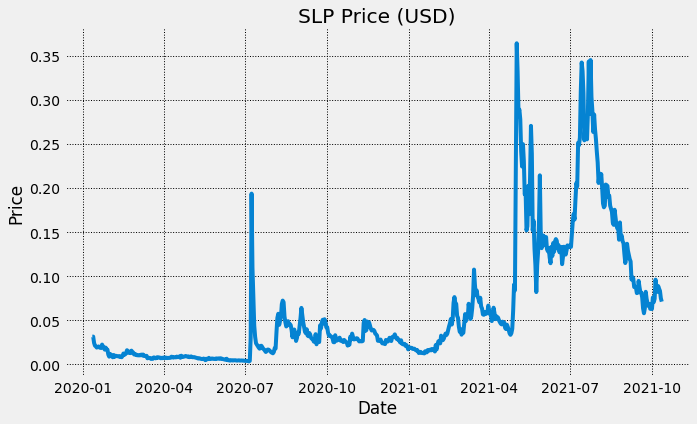

In [17]:
#Plotting SLP Price
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,6
plt.style.use(plt.style.available[6])
plt.plot(df['date'],df['price'],color='#0583D2')
plt.grid(True,color='k',linestyle=':')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SLP Price (USD)')
plt.show()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 0 to 640
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          641 non-null    datetime64[ns]
 1   price         641 non-null    float64       
 2   market_cap    641 non-null    float64       
 3   total_volume  641 non-null    float64       
 4   burned        641 non-null    float64       
 5   minted        641 non-null    float64       
 6   delta         641 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 40.1 KB


In [19]:
df.describe()

,price,market_cap,total_volume,burned,minted,delta
count,641.000000,6.410000e+02,6.410000e+02,6.410000e+02,6.410000e+02,6.410000e+02
mean,0.061995,3.792451e+07,3.421522e+07,8.935127e+06,2.195730e+07,-1.302217e+07
std,0.072552,6.658660e+07,9.862830e+07,1.834164e+07,5.439050e+07,4.110643e+07
min,0.003285,6.823771e+02,9.099685e+01,0.000000e+00,4.912000e+03,-4.097606e+08
25%,0.013017,7.632527e+03,1.380538e+03,2.100000e+04,6.948700e+04,-1.927668e+06
50%,0.031432,1.450759e+06,2.750560e+05,8.840000e+04,7.130860e+05,-2.485870e+05
75%,0.076083,5.601004e+07,1.411811e+07,1.186800e+06,5.857813e+06,-1.115400e+04
max,0.364533,2.894132e+08,1.250885e+09,1.117772e+08,4.432466e+08,2.849750e+07


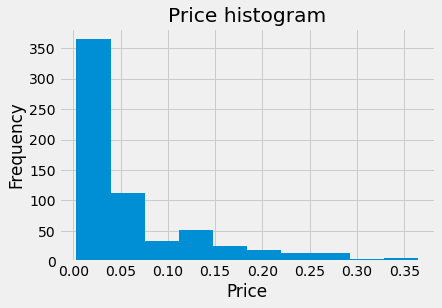

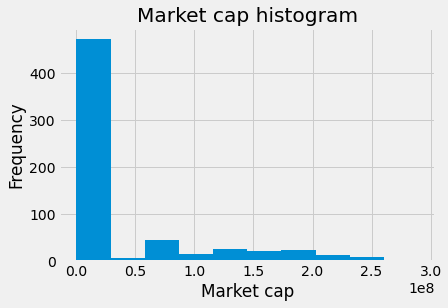

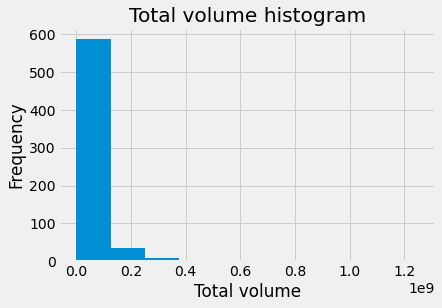

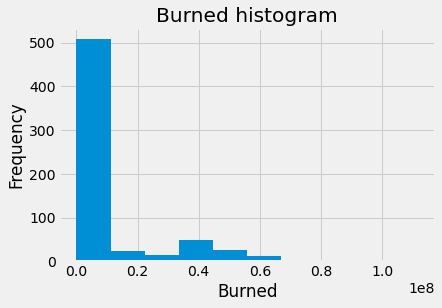

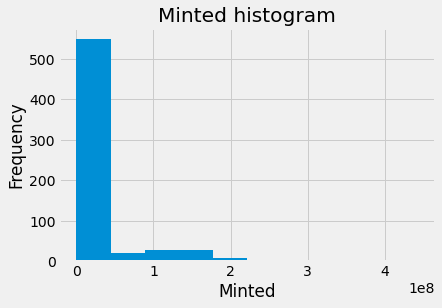

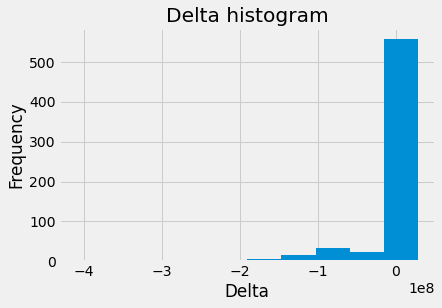

In [20]:
#Printing histograms for all numerical attributes
plt.rcParams['figure.figsize'] = [6, 4]
for i in df.columns[1:]:
    plt.style.use(plt.style.available[6])
    plt.hist(df[i])
    plt.title('%s histogram'%i.capitalize().replace('_',' '))
    plt.ylabel('Frequency')
    plt.xlabel(i.capitalize().replace('_',' '))
    plt.show()

All numerical columns seem to be not normally distributed. Normalizing is an option, but delta has
negative values, so log normalization is out.

<AxesSubplot:>

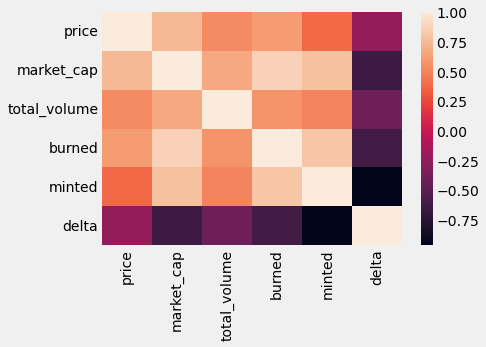

In [21]:
#Seeing the relationship of all variables
sns.heatmap(df.corr())

The reason I decided to create a new variable called delta is to avoid collinearity. All variables have a relationship with each other, and we want them to have a relationship with our output variable, price. For this reason, we are going to drop burned and minted, and use delta (the difference between burned and minted). We will also explore total_volume and market_cap since there seems to be a correlation between these two variables.

In [22]:
#Setting our input variable (market cap, total volume, delta) and output variable (price)
predictors = ['market_cap','total_volume','delta']
output_variable = 'price'

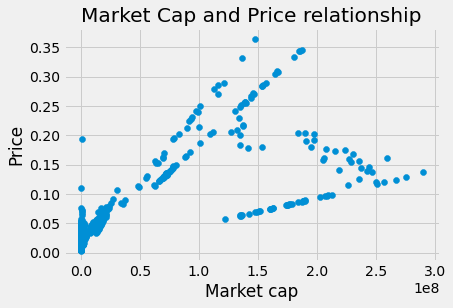

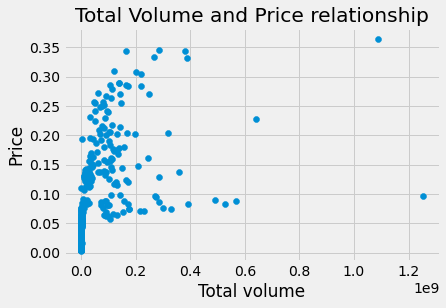

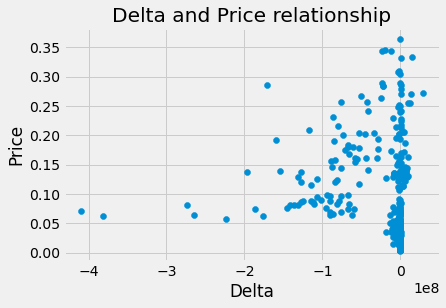

In [23]:
#Scatter plot of each predictor variable vs output variable
for predictor in predictors:
    plt.style.use(plt.style.available[6])
    plt.scatter(df[predictor],df[output_variable])
    plt.title('%s and %s relationship'%(predictor.title().replace('_',' '),output_variable.title()))
    plt.xlabel(predictor.capitalize().replace('_',' '))
    plt.ylabel(output_variable.capitalize())
    plt.show()

## Exploring outliers

In [24]:
#Get every z score and get every value where z is higher than 3.
z = np.abs(stats.zscore(df[df.columns[1:]]))
outliers= np.where(z>3)
outliers_index = outliers[0]
outliers_index

array([476, 477, 477, 478, 478, 479, 480, 549, 550, 550, 551, 552, 557,
       557, 557, 558, 559, 560, 561, 562, 564, 578, 581, 581, 593, 594,
       595, 596, 596, 596, 597, 597, 597, 600, 601, 601, 602, 603, 604,
       605, 612, 612, 613, 620, 620, 621, 622, 622, 623, 623, 624, 626,
       627, 627, 628, 628, 628, 629, 629, 630, 630, 631, 631, 632, 632,
       633, 634, 634, 635, 636, 638, 639], dtype=int64)

In [25]:
#Making a copy of the dataframe to elimante outliers
df1 = df.copy()
df1

,date,price,market_cap,total_volume,burned,minted,delta
0,2020-01-11,0.031432,4.191260e+03,1.263370e+03,21000.0,44291.0,-23291.0
1,2020-01-12,0.031423,4.036073e+03,7.548199e+02,25700.0,42146.0,-16446.0
2,2020-01-13,0.024327,3.287767e+03,1.429653e+03,38400.0,43831.0,-5431.0
3,2020-01-14,0.021101,2.911645e+03,7.488270e+02,44800.0,37664.0,7136.0
4,2020-01-15,0.020363,2.718482e+03,1.834785e+03,59000.0,60227.0,-1227.0
...,...,...,...,...,...,...,...
636,2021-10-08,0.088812,1.901225e+08,4.910256e+08,54928650.0,156887400.0,-101958750.0
637,2021-10-09,0.085835,1.842053e+08,2.867441e+08,55666950.0,182565379.0,-126898429.0
638,2021-10-10,0.083279,1.792277e+08,1.723503e+08,71891850.0,137656470.0,-65764620.0
639,2021-10-11,0.074867,1.610610e+08,1.777404e+08,67044150.0,134579340.0,-67535190.0


In [26]:
#Deleting outliers
for outlier in set(outliers_index):
    df1.drop(index=[outlier],inplace=True)
df1

,date,price,market_cap,total_volume,burned,minted,delta
0,2020-01-11,0.031432,4.191260e+03,1.263370e+03,21000.0,44291.0,-23291.0
1,2020-01-12,0.031423,4.036073e+03,7.548199e+02,25700.0,42146.0,-16446.0
2,2020-01-13,0.024327,3.287767e+03,1.429653e+03,38400.0,43831.0,-5431.0
3,2020-01-14,0.021101,2.911645e+03,7.488270e+02,44800.0,37664.0,7136.0
4,2020-01-15,0.020363,2.718482e+03,1.834785e+03,59000.0,60227.0,-1227.0
...,...,...,...,...,...,...,...
618,2021-09-20,0.075980,1.630785e+08,7.994140e+07,38289600.0,133478587.0,-95188987.0
619,2021-09-21,0.063437,1.351199e+08,1.304500e+08,36512400.0,126634723.0,-90122323.0
625,2021-09-27,0.066286,1.421442e+08,1.166047e+08,61690500.0,148316545.0,-86626045.0
637,2021-10-09,0.085835,1.842053e+08,2.867441e+08,55666950.0,182565379.0,-126898429.0


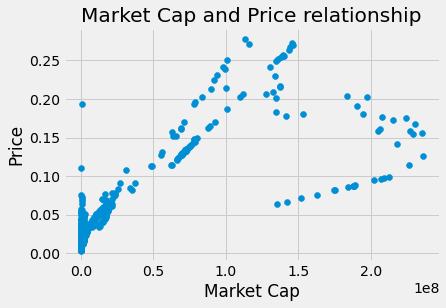

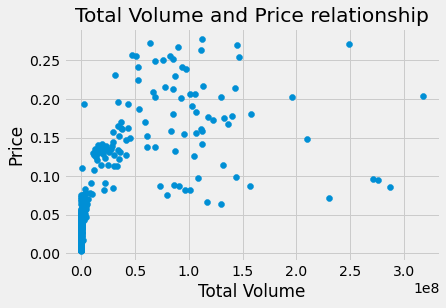

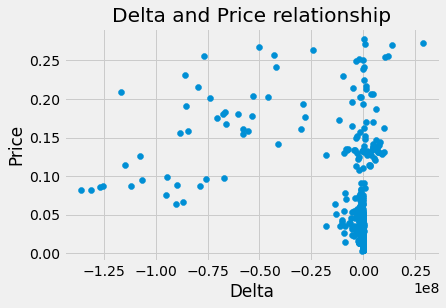

In [27]:
#Seeing the relationship between the output variable and predictors after eliminating outliers
for predictor in predictors:
    plt.style.use(plt.style.available[6])
    plt.scatter(df1[predictor],df1[output_variable])
    plt.title('%s and %s relationship'%(predictor.title().replace('_',' '),output_variable.title()))
    plt.xlabel(predictor.title().replace('_',' '))
    plt.ylabel(output_variable.title())
    plt.show()

It looks like removing the outliers helped spreading the data points.

## Model Building

In [28]:
#Setting our y variable and x variable to build our model
df1.columns
y_variable = df1['price']
x_variables = df1[['delta','market_cap','total_volume']]

In [29]:
#Splitting the data with 20% for testing and 80% for training
X_train, X_test, y_train, y_test = train_test_split(x_variables,y_variable,test_size =0.20)

In [30]:
#Training dataframe
data = pd.concat([X_train,y_train],axis=1)
data

,delta,market_cap,total_volume,price
235,-224076.0,7.726638e+05,8.395395e+04,0.064039
347,-518847.0,2.256285e+06,1.397685e+05,0.027288
185,-46302.0,9.212123e+04,2.844484e+04,0.022278
534,-7599039.0,7.289814e+07,1.505032e+07,0.135016
329,-1610313.0,1.403438e+06,1.574272e+05,0.022906
...,...,...,...,...
82,-2528.0,1.024710e+03,1.874689e+02,0.007682
413,-1887866.0,8.600112e+06,1.321473e+06,0.036734
529,-2487366.0,6.596260e+07,3.579949e+07,0.122074
353,-297142.0,1.900103e+06,1.336539e+05,0.021861


In [31]:
#P-values and coefficient of each variable
predictors = ['delta','market_cap','total_volume']
model = 'price ~'
print("{:>15} {:>25} {:>24}".format("predictor", "coef","pvalue"))
for predictor in predictors:
    model = 'price ~' + predictor
    res = smf.ols(formula = model, data = data).fit()
    print("{:>15} {:>25} {:>24}".format(predictor, res.params[predictor],res.pvalues[predictor]))

      predictor                      coef                   pvalue
          delta   -1.0282324071943515e-09   1.7161126578167102e-16
     market_cap     9.082702795321336e-10  2.2502852436863814e-102
   total_volume     9.422521574790439e-10    4.210917201436629e-64


In [32]:
#Linear regression model
all_columns = "+".join(predictors)
model = "price ~" + all_columns
res = smf.ols(formula = model, data=data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     434.7
Date:                Wed, 24 Nov 2021   Prob (F-statistic):          5.48e-135
Time:                        23:16:55   Log-Likelihood:                 956.20
No. Observations:                 473   AIC:                            -1904.
Df Residuals:                     469   BIC:                            -1888.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0272      0.002     16.290   

In [33]:
#Ploting Variance Inflation Factor to test for multicollinearity
vif_predictors = data[predictors]
vif_data = pd.DataFrame()
vif_data["predictors"] = vif_predictors.columns
vif_data["VIF"] = [variance_inflation_factor(vif_predictors.values, i) for i in range(len(vif_predictors.columns))]
vif_data

,predictors,VIF
0,delta,2.410932
1,market_cap,5.513075
2,total_volume,4.118578


A value of VIF less than 5 is usually considered good. We saw earlier that market cap and total volume had a high correlation between them. There is evidence to infer that we might have multicollinearity

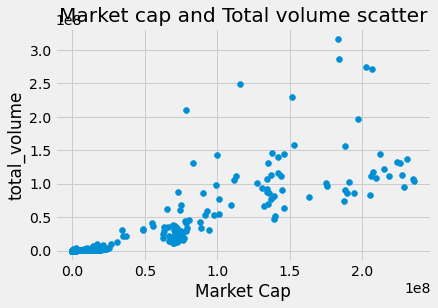

In [34]:
plt.scatter(df1['market_cap'],df1['total_volume'])
plt.title('Market cap and Total volume scatter')
plt.xlabel('Market Cap')
plt.ylabel('total_volume')
plt.show()

Let's run the model with each market cap and delta, and total volume and delta as our predictor variables

In [35]:
#Linear regression model with Market Cap and delta as input variables
predictors = ['market_cap','delta']
print('Linear Regression with predictors: Market Cap, Delta:\n')
all_columns = "+".join(predictors)
model = "price ~" + all_columns
res = smf.ols(formula = model, data=data).fit()
print(res.summary())

print('\n')
#Linear regression model with Total volume and delta as input variables
predictors = ['total_volume','delta']
print('Linear Regression with predictors: Total Volume, Delta:\n')
all_columns = "+".join(predictors)
model = "price ~" + all_columns
res = smf.ols(formula = model, data=data).fit()
print(res.summary())

Linear Regression with predictors: Market Cap, Delta:

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     653.3
Date:                Wed, 24 Nov 2021   Prob (F-statistic):          1.92e-136
Time:                        23:16:56   Log-Likelihood:                 956.19
No. Observations:                 473   AIC:                            -1906.
Df Residuals:                     470   BIC:                            -1894.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R-Squared does not increase that much when we include total volume. This is another evidence of multicolinearity. We should keep delta and market cap only even though total volume is significant to build our model

In [36]:
#Final linear regression model
predictors = ['market_cap','delta']
all_columns = "+".join(predictors)
model = "price ~" + all_columns
res = smf.ols(formula = model, data=data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     653.3
Date:                Wed, 24 Nov 2021   Prob (F-statistic):          1.92e-136
Time:                        23:16:56   Log-Likelihood:                 956.19
No. Observations:                 473   AIC:                            -1906.
Df Residuals:                     470   BIC:                            -1894.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0271      0.002     16.334      0.0

In [37]:
vif_predictors = data[predictors]
vif_data = pd.DataFrame()
vif_data["predictors"] = vif_predictors.columns
vif_data["VIF"] = [variance_inflation_factor(vif_predictors.values, i) for i in range(len(vif_predictors.columns))]
vif_data

,predictors,VIF
0,market_cap,2.410895
1,delta,2.410895


We get a value of less than 5 for each input variable. There is no evidence of multicoloniearity in the model anymore.

## Testing Predictive Model

In [38]:
#Predicting the values using the model built
predicted_values = res.predict(X_test)

In [39]:
#Creating a dataframe with the predicted values and actual values
predicted_vs_actual = pd.concat([df['date'],y_test,predicted_values],axis=1).dropna()
predicted_vs_actual.rename(columns={0:'predicted_price'},inplace=True)
predicted_vs_actual['date'] = predicted_vs_actual['date'].astype('datetime64')
predicted_vs_actual

,date,price,predicted_price
2,2020-01-13,0.024327,0.027137
5,2020-01-16,0.018997,0.027120
6,2020-01-17,0.019613,0.027112
7,2020-01-18,0.020253,0.027142
20,2020-01-31,0.011805,0.027064
...,...,...,...
572,2021-08-05,0.215982,0.098680
592,2021-08-25,0.141472,0.261166
608,2021-09-10,0.097484,0.212497
615,2021-09-17,0.087601,0.103170


In [40]:
rmse = rmse(predicted_vs_actual['price'], predicted_vs_actual['predicted_price'])
rmse

0.02656209223677118

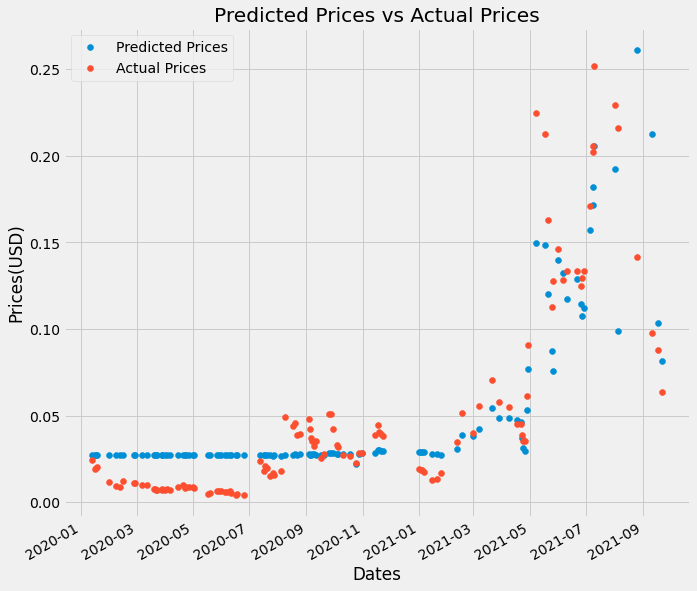

In [41]:
#Plotting the predicted prices vs actual prices
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(predicted_vs_actual['date'],predicted_vs_actual['predicted_price'],label='Predicted Prices')
plt.scatter(predicted_vs_actual['date'],predicted_vs_actual['price'],label='Actual Prices')
plt.title('Predicted Prices vs Actual Prices')
plt.xlabel('Dates')
plt.ylabel('Prices(USD)')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

The model seems to be predicting the prices from 2020-01 to 2021-01 as a straight line which does not represent the data at all. From 2021-01 onwards the model seems to be performing better

Even though our initial objective was not to plot this graph, it still shows a good representation of how the model performs. Remember that we wanted to test if there was evidence to suggest that the price of SLP was explained by the burning and minted mechanisms of the coin. We found strong evidence to suggest that, but if we wanted to predict the price of SLP with higher accuracy we would need more information, and we would want to build a forecast model, not a regression model. 

Model Stats:
- Adjusted R-Squared: 0.734
- MSE: 0.0265

Overall I am satisfied with how the project turned out. In the future I would like to revisit this project with these things in mind:

- More attributes
- More records
- Build different models and compare the accuracy of each
- Tune the preferred model
- Build a forecast model with the information gathered to better predict the price of SLP in the future
- The stats model package still flagged the model as having multicollinearity. In the future, explore the reason as to why, and try other approaches such as ridge regression.